In [102]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [103]:

X, y = fetch_openml(
    name="har",
    version=1,
    return_X_y=True,
    as_frame=True
)

print(X.shape)
print(y.value_counts())


(10299, 561)
Class
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64


In [104]:
X.dtypes.value_counts()

float64    561
Name: count, dtype: int64

In [105]:
def is_integer_like(col, tol=1e-6):
    return np.all(np.abs(col - np.round(col)) < tol)

integer_like = X.apply(is_integer_like)

integer_like[integer_like].index.tolist()


[]

In [106]:
from sklearn.model_selection import train_test_split

X_train_unnormalized, X_test_unnormalized, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
import numpy as np

def fit_standardizer(X_train_unnormalized):
    mu = X_train_unnormalized.mean(axis=0)
    sigma = X_train_unnormalized.std(axis=0, ddof=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    return mu, sigma

def transform_standardizer(X, mu, sigma):
    return (X - mu) / sigma


In [108]:
mu, sigma = fit_standardizer(X_train_unnormalized)
X_train = transform_standardizer(X_train_unnormalized, mu, sigma)
X_test  = transform_standardizer(X_test_unnormalized,  mu, sigma)

## Helpers

In [109]:
import numpy as np

def make_one_hot(y, classes):

    idx = {c:i for i,c in enumerate(classes)}
    y_idx = np.array([idx[v] for v in y], dtype=int)

    Y = np.zeros((y_idx.size, len(classes)), dtype=float)
    Y[np.arange(y_idx.size), y_idx] = 1.0
    return Y, y_idx

In [110]:
def softmax(Z: np.ndarray) -> np.ndarray:
    Z = Z - Z.max(axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

def cross_entropy(P: np.ndarray, Y: np.ndarray, eps: float = 1e-12) -> float:
    P = np.clip(P, eps, 1.0)
    return float(-(Y * np.log(P)).sum(axis=1).mean())

def classification_report(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    else:
        labels = np.asarray(labels)

    report = {}
    report['classes'] = {}

    accuracy = (y_true == y_pred).mean()

    precision_sum = 0.0
    recall_sum = 0.0
    f1_sum = 0.0
    total_support = len(y_true)

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_true == label) & (y_pred != label))
        support = np.sum(y_true == label)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        report['classes'][label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': support
        }

        precision_sum += precision
        recall_sum += recall
        f1_sum += f1

    n_classes = len(labels)
    report['macro_avg'] = {
        'precision': precision_sum / n_classes,
        'recall': recall_sum / n_classes,
        'f1-score': f1_sum / n_classes,
        'support': total_support
    }
    weighted_precision = sum(report['classes'][label]['precision'] * report['classes'][label]['support']
                            for label in labels) / total_support
    weighted_recall = sum(report['classes'][label]['recall'] * report['classes'][label]['support']
                         for label in labels) / total_support
    weighted_f1 = sum(report['classes'][label]['f1-score'] * report['classes'][label]['support']
                     for label in labels) / total_support

    report['weighted_avg'] = {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1-score': weighted_f1,
        'support': total_support
    }

    report['accuracy'] = accuracy

    return report

def print_classification_report(y_true, y_pred, labels=None, digits=4):
    report = classification_report(y_true, y_pred, labels)

    print(f"{'':<15} {'precision':<12} {'recall':<12} {'f1-score':<12} {'support':<12}")
    print("-" * 65)

    for label in sorted(report['classes'].keys()):
        metrics = report['classes'][label]
        print(f"{str(label):<15} {metrics['precision']:<12.{digits}f} {metrics['recall']:<12.{digits}f} "
              f"{metrics['f1-score']:<12.{digits}f} {int(metrics['support']):<12}")

    print("-" * 65)

    macro = report['macro_avg']
    print(f"{'macro avg':<15} {macro['precision']:<12.{digits}f} {macro['recall']:<12.{digits}f} "
          f"{macro['f1-score']:<12.{digits}f} {int(macro['support']):<12}")

    weighted = report['weighted_avg']
    print(f"{'weighted avg':<15} {weighted['precision']:<12.{digits}f} {weighted['recall']:<12.{digits}f} "
          f"{weighted['f1-score']:<12.{digits}f} {int(weighted['support']):<12}")

    print("-" * 65)

    print(f"{'accuracy':<15} {report['accuracy']:<12.{digits}f} {int(report['weighted_avg']['support']):<12}")
    print()

In [111]:
from abc import ABC, abstractmethod

class BaseModel(ABC):
    @abstractmethod
    def fit(self, X_train, y_train):
        pass

    @abstractmethod
    def predict(self, X):
        pass

## PCA

In [112]:
class PCA(BaseModel):

    def __init__(self, k):
        self.k = k
        self.W = None
        self.mean_vec = None
        self.explained_ratio = None

    def fit(self, X_train, y_train=None):
        X = np.asarray(X_train, dtype=float)

        self.mean_vec = X.mean(axis=0)
        Xc = X - self.mean_vec

        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        self.W = Vt.T[:, :self.k]

        n = X.shape[0]
        eigvals = (S**2) / (n - 1)
        self.explained_ratio = eigvals[:self.k] / eigvals.sum()

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        Xc = X - self.mean_vec
        return Xc @ self.W


In [113]:
k = 2
pca = PCA(k=k)
pca.fit(X_train, y_train=None)

T_train = pca.predict(X_train)
T_test = pca.predict(X_test)

print(f"PCA components shape: {pca.W.shape}")
print(f"Cumulative explained variance (k={k}): {pca.explained_ratio.sum():.3f}")


PCA components shape: (561, 2)
Cumulative explained variance (k=2): 0.570


In [114]:
T_train_np = np.asarray(T_train)
y_train_np = np.asarray(y_train)

T_test_np = np.asarray(T_test)
y_test_np = np.asarray(y_test)

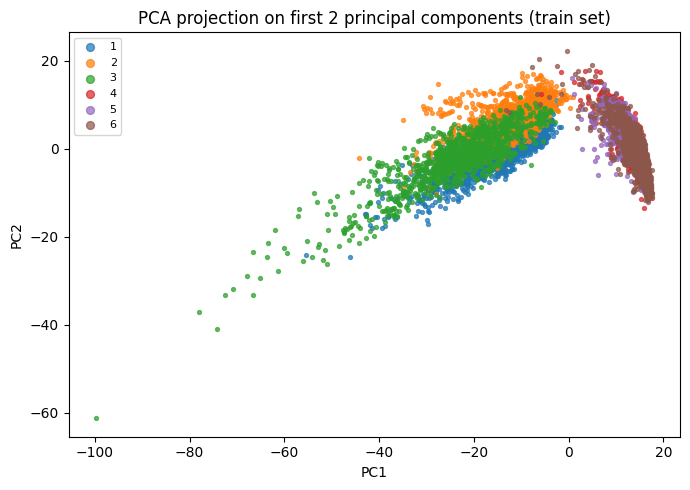

In [115]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 5))

labels = np.unique(y_train)

for lab in labels:
    idx = (y_train == lab)
    plt.scatter(
        T_train_np[idx, 0],
        T_train_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


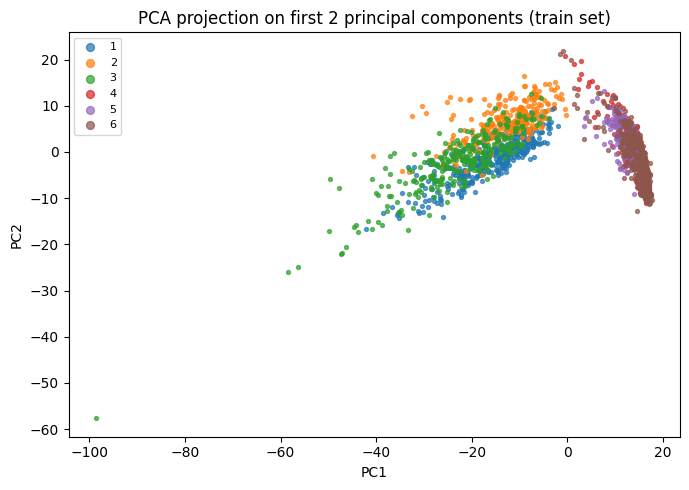

In [116]:
plt.figure(figsize=(7, 5))

labels = np.unique(y_test)

for lab in labels:
    idx = (y_test == lab)
    plt.scatter(
        T_test_np[idx, 0],
        T_test_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


## Least Squares Classifier

In [117]:
class LeastSquaresClassifier(BaseModel):

    def __init__(self, lam=1e-2, add_bias=True):
        self.lam = lam
        self.add_bias = add_bias
        self.W = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        Y, _ = make_one_hot(y, self.classes)

        if self.add_bias:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        d = X.shape[1]
        A = X.T @ X + self.lam * np.eye(d)
        B = X.T @ Y

        self.W = np.linalg.solve(A, B)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if self.add_bias:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        scores = X @ self.W
        pred_idx = np.argmax(scores, axis=1)
        return self.classes[pred_idx]


In [118]:
model = LeastSquaresClassifier(lam=1e-2, add_bias=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("\nClassification Report:")
print_classification_report(y_test, y_pred)

Test Accuracy: 0.9752427184466019

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9853       0.9963       0.9908       270         
3               1.0000       0.9965       0.9982       284         
4               0.9434       0.9284       0.9358       377         
5               0.9380       0.9407       0.9394       354         
6               0.9927       1.0000       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9761       0.9765       0.9763       2060        
weighted avg    0.9751       0.9752       0.9752       2060        
-----------------------------------------------------------------
accuracy        0.9752       2060        



## Softmax Logistic Regression

In [119]:
def one_hot_from_indices(y_idx: np.ndarray, C: int) -> np.ndarray:
    Y = np.zeros((y_idx.size, C), dtype=float)
    Y[np.arange(y_idx.size), y_idx] = 1.0
    return Y


class LogisticRegression(BaseModel):

    def __init__(self, lr=0.05, epochs=20, batch_size=128, lam=0.0, seed=42):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lam = lam
        self.seed = seed
        self.W = None
        self.b = None
        self.classes = None
        self.history = None



    def fit(self, X_train, y_train, X_test, y_test):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        C = self.classes.size
        class_to_idx = {c: i for i, c in enumerate(self.classes)}
        y_idx = np.array([class_to_idx[v] for v in y], dtype=int)

        X_test_arr = np.asarray(X_test, dtype=float)
        y_test_arr = np.asarray(y_test)
        y_test_idx = np.array([class_to_idx[v] for v in y_test_arr], dtype=int)
        Y_test = one_hot_from_indices(y_test_idx, C)

        n, d = X.shape
        rng = np.random.default_rng(self.seed)

        self.W = rng.normal(loc=0.0, scale=0.01, size=(C, d))
        self.b = np.zeros(C, dtype=float)

        self.history = {"loss": [], "test_loss": []}

        for epoch in range(1, self.epochs + 1):
            perm = rng.permutation(n)
            Xs = X[perm]
            ys = y_idx[perm]

            epoch_loss = 0.0
            n_batches = 0

            for start in range(0, n, self.batch_size):
                end = min(start + self.batch_size, n)
                Xb = Xs[start:end]
                yb = ys[start:end]
                Yb = one_hot_from_indices(yb, C)

                Z = Xb @ self.W.T + self.b
                P = softmax(Z)

                batch_loss = cross_entropy(P, Yb)
                epoch_loss += batch_loss
                n_batches += 1

                B = Xb.shape[0]
                G = (P - Yb) / B
                dW = G.T @ Xb
                db = G.sum(axis=0)

                if self.lam > 0:
                    dW += self.lam * self.W

                self.W -= self.lr * dW
                self.b -= self.lr * db

            self.history["loss"].append(epoch_loss / n_batches)

            Z_test = X_test_arr @ self.W.T + self.b
            P_test = softmax(Z_test)
            test_loss = cross_entropy(P_test, Y_test)
            self.history["test_loss"].append(test_loss)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        P = softmax(X @ self.W.T + self.b)
        pred_idx = np.argmax(P, axis=1)
        return self.classes[pred_idx]


Test Accuracy: 0.9694174757281553
Last train loss: 0.07568248883209706
Last test loss: 0.09099516924947282

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9919       0.9919       0.9919       369         
2               0.9851       0.9815       0.9833       270         
3               0.9825       0.9894       0.9860       284         
4               0.9288       0.9337       0.9312       377         
5               0.9343       0.9237       0.9290       354         
6               0.9975       1.0000       0.9988       406         
-----------------------------------------------------------------
macro avg       0.9700       0.9700       0.9700       2060        
weighted avg    0.9694       0.9694       0.9694       2060        
-----------------------------------------------------------------
accuracy        0.9694       2060        



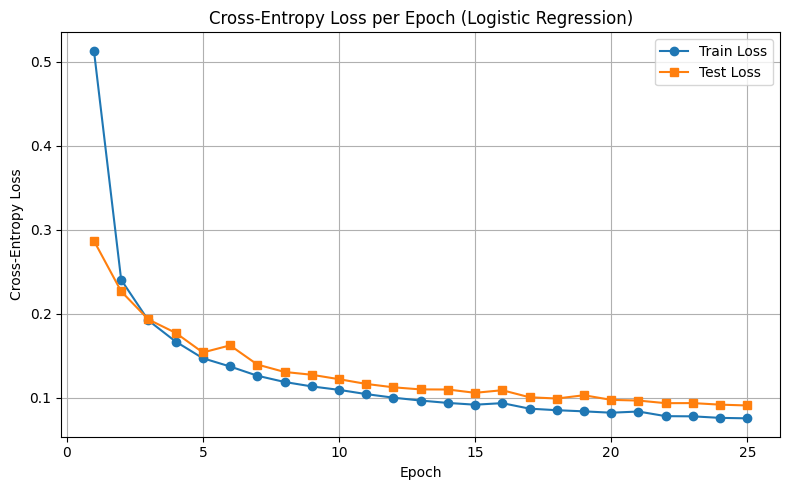

In [120]:
model = LogisticRegression(lr=0.05, epochs=25, batch_size=256, lam=1e-4)
model.fit(X_train, y_train, X_test, y_test)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("Last train loss:", model.history["loss"][-1])
print("Last test loss:", model.history["test_loss"][-1])
print("\nClassification Report:")
print_classification_report(y_test, y_pred)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
epochs = range(1, len(model.history["loss"]) + 1)
plt.plot(epochs, model.history["loss"], label="Train Loss", marker="o")
plt.plot(epochs, model.history["test_loss"], label="Test Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross-Entropy Loss per Epoch (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## KNN

In [121]:
class KNNClassifier(BaseModel):

    def __init__(self, k=1):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = np.asarray(X_train, dtype=float)
        self.y_train = np.asarray(y_train)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        k = int(self.k)
        if k < 1 or k > self.X_train.shape[0]:
            raise ValueError("k must be in [1, n_train]")

        te_norm = np.sum(X**2, axis=1, keepdims=True)
        tr_norm = np.sum(self.X_train**2, axis=1, keepdims=True).T
        d2 = te_norm + tr_norm - 2 * (X @ self.X_train.T)
        d2 = np.maximum(d2, 0.0)

        nn_idx = np.argpartition(d2, kth=k-1, axis=1)[:, :k]

        y_pred = []
        for i in range(nn_idx.shape[0]):
            neigh_labels = self.y_train[nn_idx[i]]
            values, counts = np.unique(neigh_labels, return_counts=True)
            y_pred.append(values[np.argmax(counts)])

        return np.array(y_pred, dtype=self.y_train.dtype)


In [122]:
results = []

for k in range(1, 11):
    model = KNNClassifier(k=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = (y_pred == np.asarray(y_test)).mean()
    results.append((k, acc))
    print(f"k={k:2d} | accuracy={acc:.4f}")

best_k, best_acc = max(results, key=lambda t: t[1])
print(f"\nBest k in [1,10]: {best_k} (accuracy={best_acc:.4f})")

print("\nClassification Report for Best KNN (k={}):".format(best_k))
best_knn_model = KNNClassifier(k=best_k)
best_knn_model.fit(X_train, y_train)
best_knn_pred = best_knn_model.predict(X_test)
print_classification_report(y_test, best_knn_pred)


k= 1 | accuracy=0.9631
k= 2 | accuracy=0.9451
k= 3 | accuracy=0.9587
k= 4 | accuracy=0.9568
k= 5 | accuracy=0.9597
k= 6 | accuracy=0.9534
k= 7 | accuracy=0.9553
k= 8 | accuracy=0.9553
k= 9 | accuracy=0.9524
k=10 | accuracy=0.9519

Best k in [1,10]: 1 (accuracy=0.9631)

Classification Report for Best KNN (k=1):
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9892       0.9946       0.9919       369         
2               0.9889       0.9889       0.9889       270         
3               0.9894       0.9824       0.9859       284         
4               0.9311       0.8966       0.9135       377         
5               0.8898       0.9350       0.9118       354         
6               1.0000       0.9901       0.9950       406         
-----------------------------------------------------------------
macro avg       0.9647       0.9646       0.9645       2060        
weighted avg

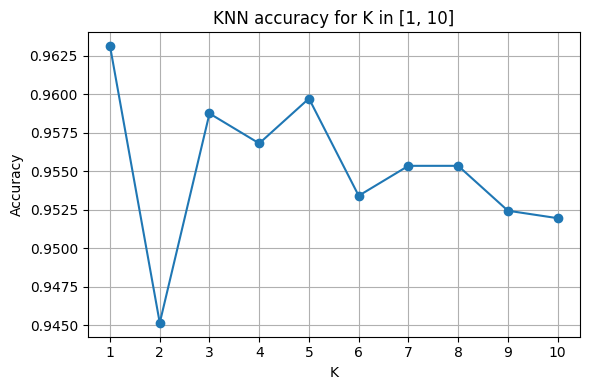

In [123]:
import matplotlib.pyplot as plt

ks = [k for k, _ in results]
accs = [a for _, a in results]

plt.figure(figsize=(6,4))
plt.plot(ks, accs, marker="o")
plt.xticks(ks)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN accuracy for K in [1, 10]")
plt.grid(True)
plt.tight_layout()
plt.show()


## Gaussian Naive Bayes Classifier


In [124]:
class GaussianNaiveBayes(BaseModel):

    def __init__(self, eps=1e-9):
        self.eps = eps
        self.priors = None
        self.means = None
        self.vars_ = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        C = self.classes.size
        n, d = X.shape

        self.priors = np.zeros(C, dtype=float)
        self.means = np.zeros((C, d), dtype=float)
        self.vars_ = np.zeros((C, d), dtype=float)

        for i, c in enumerate(self.classes):
            Xc = X[y == c]
            self.priors[i] = Xc.shape[0] / n
            self.means[i] = Xc.mean(axis=0)
            self.vars_[i] = Xc.var(axis=0, ddof=0) + self.eps

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        m, d = X.shape
        C = self.classes.size

        log_priors = np.log(self.priors)

        X3 = X[:, None, :]
        mu = self.means[None, :, :]
        va = self.vars_[None, :, :]

        log_det_term = -0.5 * np.sum(np.log(2.0 * np.pi * va), axis=2)
        quad_term = -0.5 * np.sum(((X3 - mu) ** 2) / va, axis=2)

        log_post = log_det_term + quad_term + log_priors[None, :]

        pred_idx = np.argmax(log_post, axis=1)
        return self.classes[pred_idx]


In [125]:
model = GaussianNaiveBayes(eps=1e-9)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("\nClassification Report:")
print_classification_report(y_test, y_pred)


Test Accuracy: 0.746116504854369

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9303       0.7236       0.8140       369         
2               0.6568       0.9074       0.7621       270         
3               0.7614       0.7641       0.7627       284         
4               0.5489       0.8939       0.6801       377         
5               0.8138       0.3333       0.4729       354         
6               0.9916       0.8695       0.9265       406         
-----------------------------------------------------------------
macro avg       0.7838       0.7486       0.7364       2060        
weighted avg    0.7934       0.7461       0.7392       2060        
-----------------------------------------------------------------
accuracy        0.7461       2060        



MLP

## One-vs-Rest SVM (OVR-SVM)

In the lab, the problem was binary classification. Here we use the One-vs-Rest approach:
- We train one SVM for each class
- For each SVM, the positive class is the active class (+1) and all others are negative (-1)
- The final label is the label of the SVM with the highest score

In [126]:
class SVM(BaseModel):

    def __init__(self, lr=0.01, epochs=10, lam=1e-4, seed=42):
        self.lr = lr
        self.epochs = epochs
        self.lam = lam
        self.seed = seed
        self.W = None
        self.b = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        Ws = []
        bs = []

        for idx, c in enumerate(self.classes):
            y_pm1 = np.where(y == c, 1.0, -1.0)
            w, b = self._fit_linear_svm_sgd(X, y_pm1, seed=self.seed + idx)
            Ws.append(w)
            bs.append(b)

        self.W = np.vstack(Ws)
        self.b = np.array(bs, dtype=float)
        return self

    def _fit_linear_svm_sgd(self, X, y_pm1, seed):
        n, d = X.shape
        rng = np.random.default_rng(seed)
        w = np.zeros(d, dtype=float)
        b = 0.0

        for epoch in range(self.epochs):
            perm = rng.permutation(n)
            for i in perm:
                xi = X[i]
                yi = y_pm1[i]
                margin = yi * (xi @ w + b)

                if margin >= 1.0:
                    w -= self.lr * (self.lam * w)
                else:
                    w -= self.lr * (self.lam * w - yi * xi)
                    b -= self.lr * (-yi)

        return w, b

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        scores = X @ self.W.T + self.b
        pred_idx = np.argmax(scores, axis=1)
        return self.classes[pred_idx]


In [127]:
model = SVM(lr=0.01, epochs=10, lam=1e-4, seed=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("\nClassification Report:")
print_classification_report(y_test, y_pred)


Test Accuracy: 0.962135922330097

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9946       1.0000       0.9973       369         
2               0.9926       0.9889       0.9907       270         
3               0.9965       0.9965       0.9965       284         
4               0.8451       0.9841       0.9093       377         
5               0.9828       0.8079       0.8868       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9686       0.9629       0.9634       2060        
weighted avg    0.9663       0.9621       0.9618       2060        
-----------------------------------------------------------------
accuracy        0.9621       2060        



## K-Means Clustering

In [128]:
class KMeans(BaseModel):

    def __init__(self, k, max_iters=100, seed=42):
        self.k = k
        self.max_iters = max_iters
        self.seed = seed
        self.centroids = None

    def fit(self, X_train, y_train=None):
        X = np.asarray(X_train, dtype=float)
        n, d = X.shape
        rng = np.random.default_rng(self.seed)

        idx = rng.choice(n, size=self.k, replace=False)
        self.centroids = X[idx].copy()

        labels = np.zeros(n, dtype=int)

        for it in range(self.max_iters):
            x_norm = np.sum(X**2, axis=1, keepdims=True)
            c_norm = np.sum(self.centroids**2, axis=1, keepdims=True).T
            d2 = x_norm + c_norm - 2 * (X @ self.centroids.T)
            d2 = np.maximum(d2, 0.0)

            new_labels = np.argmin(d2, axis=1)

            if np.array_equal(new_labels, labels) and it > 0:
                break
            labels = new_labels

            for j in range(self.k):
                pts = X[labels == j]
                if pts.shape[0] > 0:
                    self.centroids[j] = pts.mean(axis=0)
                else:
                    self.centroids[j] = X[rng.integers(0, n)]

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        x_norm = np.sum(X**2, axis=1, keepdims=True)
        c_norm = np.sum(self.centroids**2, axis=1, keepdims=True).T
        d2 = x_norm + c_norm - 2 * (X @ self.centroids.T)
        d2 = np.maximum(d2, 0.0)

        return np.argmin(d2, axis=1)


Number of clusters: 6
Clusters found: [0 1 2 3 4 5]
Explained variance (PC1+PC2): 0.570


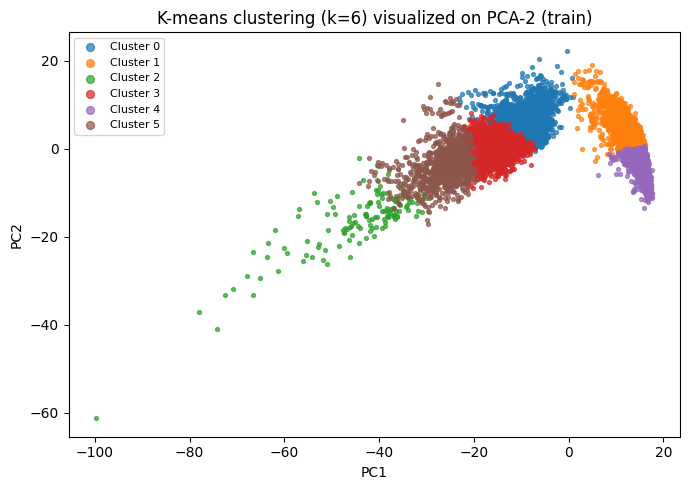

In [129]:
k_clusters = len(np.unique(y_train))
model = KMeans(k=k_clusters, max_iters=100, seed=42)
model.fit(X_train, y_train=None)

clabels = model.predict(X_train)

pca2 = PCA(k=2)
pca2.fit(X_train, y_train=None)
Ttr2 = pca2.predict(X_train)
Ttr2_np = np.asarray(Ttr2)

print(f"Number of clusters: {k_clusters}")
print(f"Clusters found: {np.unique(clabels)}")
print(f"Explained variance (PC1+PC2): {pca2.explained_ratio.sum():.3f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for c in range(k_clusters):
    idx = (clabels == c)
    plt.scatter(Ttr2_np[idx, 0], Ttr2_np[idx, 1], s=8, alpha=0.7, label=f"Cluster {c}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-means clustering (k={k_clusters}) visualized on PCA-2 (train)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


# Scikit learn PCA

In [130]:
from sklearn.preprocessing import StandardScaler

In [131]:
scaler = StandardScaler(with_mean=True, with_std=True)

# fit ONLY on training data
scaler.fit(X_train_unnormalized)

# transform train & test
X_train = scaler.transform(X_train_unnormalized)
X_test  = scaler.transform(X_test_unnormalized)

In [132]:
from sklearn.decomposition import PCA

k = 2  

pca = PCA(n_components=k, svd_solver="full", random_state=42)
pca.fit(X_train)   # X_train ήδη standardized


T_train = pca.transform(X_train)
T_test  = pca.transform(X_test)

W = pca.components_.T                 # (d, k)
explained_ratio = pca.explained_variance_ratio_

print(f"PCA components shape: {W.shape}")
print(f"Cumulative explained variance (k={k}): {explained_ratio.sum():.3f}")


PCA components shape: (561, 2)
Cumulative explained variance (k=2): 0.570


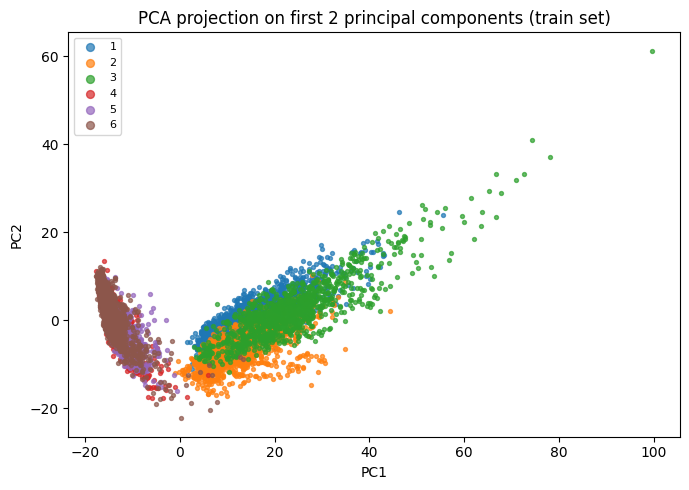

In [133]:
import matplotlib.pyplot as plt

T_train_np = np.asarray(T_train)
y_train_np = np.asarray(y_train)

plt.figure(figsize=(7, 5))
labels = np.unique(y_train_np)

for lab in labels:
    idx = (y_train_np == lab)
    plt.scatter(T_train_np[idx, 0], T_train_np[idx, 1], s=8, alpha=0.7, label=str(lab))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()

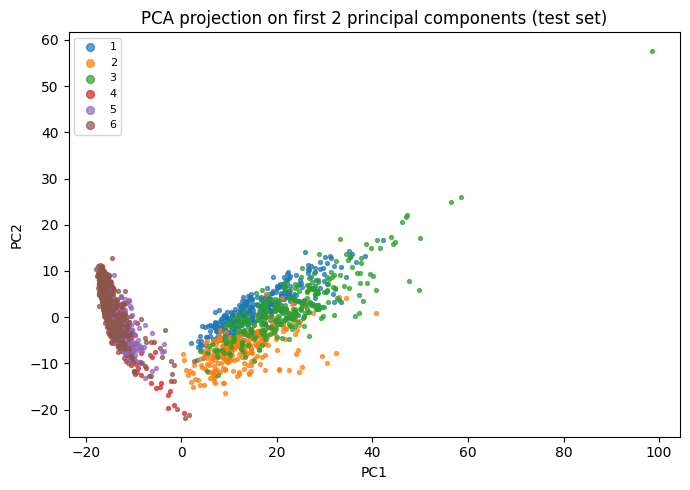

In [134]:
T_test_np = np.asarray(T_test)
y_test_np = np.asarray(y_test)

plt.figure(figsize=(7, 5))
labels = np.unique(y_test_np)

for lab in labels:
    idx = (y_test_np == lab)
    plt.scatter(T_test_np[idx, 0], T_test_np[idx, 1], s=8, alpha=0.7, label=str(lab))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (test set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


# Scikit Learn Least Squares

In [135]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report

lam = 1e-2

clf = RidgeClassifier(alpha=lam, fit_intercept=True)  # intercept = bias
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9752427184466019
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       369
           2       0.99      1.00      0.99       270
           3       1.00      1.00      1.00       284
           4       0.94      0.93      0.94       377
           5       0.94      0.94      0.94       354
           6       0.99      1.00      1.00       406

    accuracy                           0.98      2060
   macro avg       0.98      0.98      0.98      2060
weighted avg       0.98      0.98      0.98      2060



# Scikit Learn Logistic Regression 

Test Accuracy: 0.9718446601941747
Last train loss: 0.08211420562060763
Last test loss: 0.18875053769342306

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       369
           2       0.98      1.00      0.99       270
           3       0.99      0.98      0.99       284
           4       0.94      0.93      0.94       377
           5       0.94      0.94      0.94       354
           6       0.99      1.00      0.99       406

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060



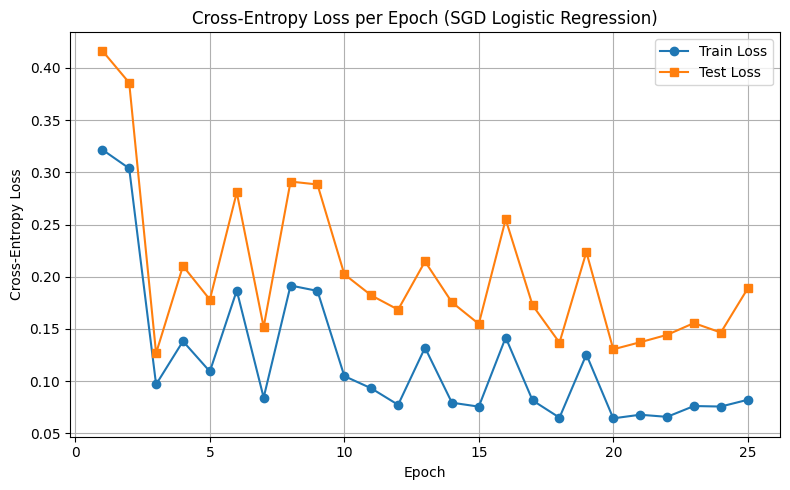

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss



lr = 0.05
epochs = 25
lam = 1e-4
seed = 42

classes = np.unique(y_train)

sgd = SGDClassifier(
    loss="log_loss",        
    penalty="l2",
    alpha=lam,              # L2 strength 
    learning_rate="constant",
    eta0=lr,
    fit_intercept=True,
    random_state=seed,
    average=False
)

train_loss_hist = []
test_loss_hist = []

for ep in range(epochs):
    # one "epoch": train once over the whole training set
    sgd.partial_fit(X_train, y_train, classes=classes)

    # probabilities for log-loss
    p_train = sgd.predict_proba(X_train)
    p_test  = sgd.predict_proba(X_test)

    train_loss = log_loss(y_train, p_train)
    test_loss  = log_loss(y_test, p_test)

    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)


y_pred = sgd.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("Last train loss:", train_loss_hist[-1])
print("Last test loss:", test_loss_hist[-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot losses
plt.figure(figsize=(8, 5))
ep_axis = range(1, epochs + 1)
plt.plot(ep_axis, train_loss_hist, label="Train Loss", marker="o")
plt.plot(ep_axis, test_loss_hist, label="Test Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross-Entropy Loss per Epoch (SGD Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scikit Learn KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

results = []

for k in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results.append((k, acc))
    print(f"k={k:2d} | accuracy={acc:.4f}")

best_k, best_acc = max(results, key=lambda t: t[1])
print(f"\nBest k in [1,10]: {best_k} (accuracy={best_acc:.4f})")

print(f"\nClassification Report for Best KNN (k={best_k}):")
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric="minkowski", p=2)
best_knn.fit(X_train, y_train)
best_pred = best_knn.predict(X_test)
print(classification_report(y_test, best_pred))

k= 1 | accuracy=0.9631
k= 2 | accuracy=0.9451
k= 3 | accuracy=0.9587
k= 4 | accuracy=0.9568
k= 5 | accuracy=0.9597
k= 6 | accuracy=0.9534
k= 7 | accuracy=0.9553
k= 8 | accuracy=0.9553
k= 9 | accuracy=0.9524
k=10 | accuracy=0.9519

Best k in [1,10]: 1 (accuracy=0.9631)

Classification Report for Best KNN (k=1):
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       369
           2       0.99      0.99      0.99       270
           3       0.99      0.98      0.99       284
           4       0.93      0.90      0.91       377
           5       0.89      0.94      0.91       354
           6       1.00      0.99      1.00       406

    accuracy                           0.96      2060
   macro avg       0.96      0.96      0.96      2060
weighted avg       0.96      0.96      0.96      2060



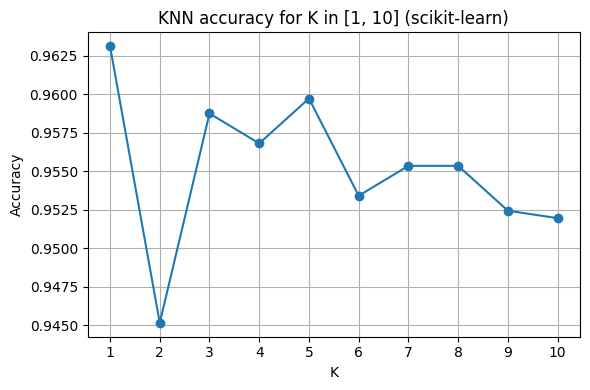

In [138]:
ks = [k for k, _ in results]
accs = [a for _, a in results]

plt.figure(figsize=(6, 4))
plt.plot(ks, accs, marker="o")
plt.xticks(ks)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN accuracy for K in [1, 10] (scikit-learn)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scikit Learn GNB 

In [ ]:
from sklearn.naive_bayes import GaussianNB

eps = 1e-9  

gnb = GaussianNB(var_smoothing=eps)   
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.746116504854369

Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.72      0.81       369
           2       0.66      0.91      0.76       270
           3       0.76      0.76      0.76       284
           4       0.55      0.89      0.68       377
           5       0.81      0.33      0.47       354
           6       0.99      0.87      0.93       406

    accuracy                           0.75      2060
   macro avg       0.78      0.75      0.74      2060
weighted avg       0.79      0.75      0.74      2060



# Scikit Learn SVM 

In [140]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
 
lam = 1e-4  

C = 1.0 / lam

svm = OneVsRestClassifier(
    LinearSVC(C=C, loss="hinge", max_iter=5000, random_state=42)
)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

c:\Users\anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy: 0.9752427184466019

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       369
           2       0.99      0.99      0.99       270
           3       1.00      0.98      0.99       284
           4       0.95      0.94      0.95       377
           5       0.93      0.96      0.94       354
           6       0.99      1.00      1.00       406

    accuracy                           0.98      2060
   macro avg       0.98      0.98      0.98      2060
weighted avg       0.98      0.98      0.98      2060



# Scikit learn Kmeans

Number of clusters: 6
Clusters found: [0 1 2 3 4 5]
Explained variance (PC1+PC2): 0.570


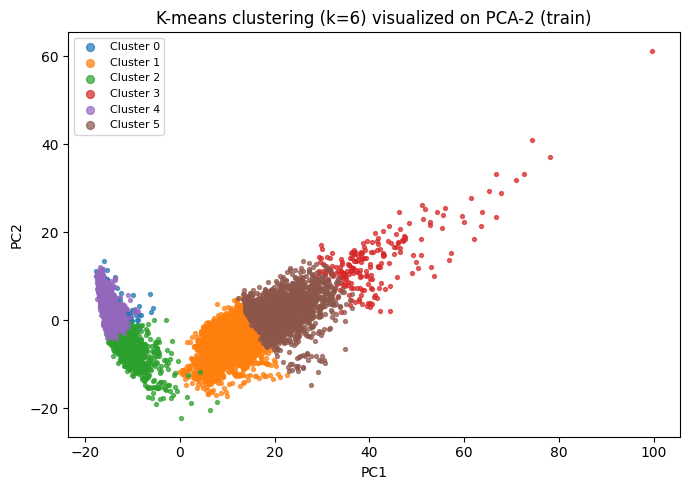

In [ ]:
from sklearn.cluster import KMeans

k_clusters = len(np.unique(y_train))

kmeans = KMeans(
    n_clusters=k_clusters,
    max_iter=100,
    n_init=10,          
    random_state=42
)

kmeans.fit(X_train)
clabels = kmeans.labels_   


pca2 = PCA(n_components=2, svd_solver="full", random_state=42)
Ttr2 = pca2.fit_transform(X_train)
Ttr2_np = np.asarray(Ttr2)

print(f"Number of clusters: {k_clusters}")
print(f"Clusters found: {np.unique(clabels)}")
print(f"Explained variance (PC1+PC2): {pca2.explained_variance_ratio_.sum():.3f}")

plt.figure(figsize=(7, 5))

for c in range(k_clusters):
    idx = (clabels == c)
    plt.scatter(
        Ttr2_np[idx, 0],
        Ttr2_np[idx, 1],
        s=8,
        alpha=0.7,
        label=f"Cluster {c}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-means clustering (k={k_clusters}) visualized on PCA-2 (train)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()
